# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [11]:
f'P = {Pref * 1e-6:.1f} MPa'

'P = 1.0 MPa'

In [19]:
# Drive parameters
drive_freq = 7  # presynaptic drive frequency (Hz)
noise = 0.5  # noise factor

# Stimulus parameters
start = 200 # start time (ms)
dur = 150  # duration (ms)
Pref = 1e6  # pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = np.linspace(0, 2 * Iref, 10)  # range of intensities to sweep

# List of sweep metrics to plot
sweep_metrics = [
    'ΔFR/FR',  # relative change in firing rate
]

# Simulation parameters
tstop = 700  # default simulation duration (ms)
nreps = 1  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'drive': [
        f'frequency = {drive_freq} Hz',
        f'noise factor = {noise}'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 03/12/2023 14:00:42: Input parameters:
   - drive:
       - frequency = 7 Hz
       - noise factor = 0.5
   - stimulus:
       - start = 200 ms
       - duration = 150 ms
       - P = 1.0 MPa <-> I = 30.91 W/cm2
       - range of intensities = 0.00 - 61.83 W/cm2
   - simulation:
       - duration = 700 ms
       - number of repetitions (for sweeps) = 1


## Network model

In [20]:
# Parameters of all stimulus and temperature-dependent components
params = dict(
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=0.58e-9 / (NeuralNetwork.Acell * NeuralNetwork.UM_TO_CM**2),  # S/cm2
    iStimbar=1e-3,  # mA/cm2
    iStimx0=200,  # W/cm2
    iStimdx=50,  # W/cm2
)

# Initialize 3-nodes model, with:
# - no M-type K+ current
# - all temperature-dependent conductances
nnodes = 3
model = NeuralNetwork(
    nnodes, 
    gMbar=0,
    **params
)

 03/12/2023 14:00:42: NeuralNetwork(3): created 3 nodes
 03/12/2023 14:00:42: NeuralNetwork(3): connecting all node pairs
 03/12/2023 14:00:42: NeuralNetwork(3): setting gMbar = 0 on all nodes
 03/12/2023 14:00:42: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 03/12/2023 14:00:42: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 03/12/2023 14:00:42: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 03/12/2023 14:00:42: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 03/12/2023 14:00:42: NeuralNetwork(3): setting iStimbar = 0.001 on all nodes
 03/12/2023 14:00:42: NeuralNetwork(3): setting iStimdx = 50 on all nodes


 03/12/2023 14:00:42: NeuralNetwork(3): initialized


## Simulations

### Set baseline drive and inspect activity with various synaptic coupling strengths

 03/12/2023 14:00:43: NeuralNetwork(3): setting pre-synaptic drive on nodes [0, 1, 2]
 03/12/2023 14:00:43: creating 7.0 ± 3.5 Hz pre-synaptic drive starting at 0.0 ms
 03/12/2023 14:00:43: creating 7.0 ± 3.5 Hz pre-synaptic drive starting at 0.0 ms
 03/12/2023 14:00:43: creating 7.0 ± 3.5 Hz pre-synaptic drive starting at 0.0 ms


 03/12/2023 14:00:43: NeuralNetwork(3): disabled currents: iM, iNaKPump
 03/12/2023 14:00:43: NeuralNetwork(3): simulating for 700.00 ms
 03/12/2023 14:00:43: NeuralNetwork(3): extracting output results
 03/12/2023 14:00:44: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.0 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 03/12/2023 14:00:44: NeuralNetwork(3): number of spikes:
    - node 0: n = 5 spikes
    - node 1: n = 3 spikes
    - node 2: n = 4 spikes
 03/12/2023 14:00:44: NeuralNetwork(3): firing rate:
    - node 0: FR = 10.6 ±2.6 Hz
    - node 1: FR = 4.1 ±0.5 Hz
    - node 2: FR = 6.1 ±3.4 Hz
 03/12/2023 14:00:44: NeuralNetwork(3): plotting results


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


 03/12/2023 14:00:49: NeuralNetwork(3): plotting results
 03/12/2023 14:00:50: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2


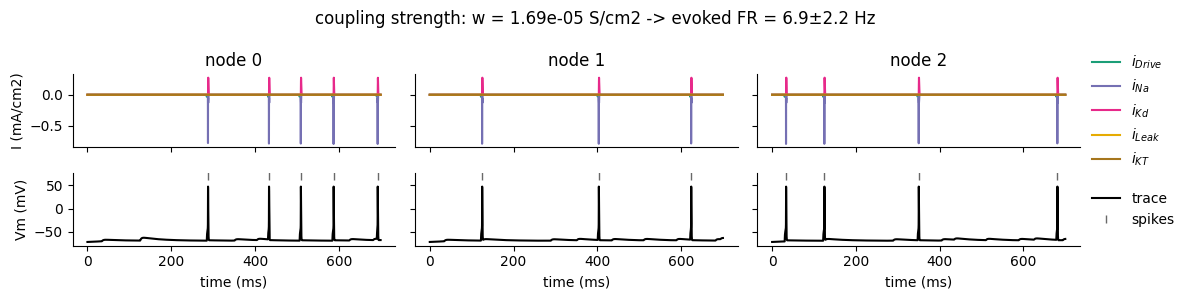

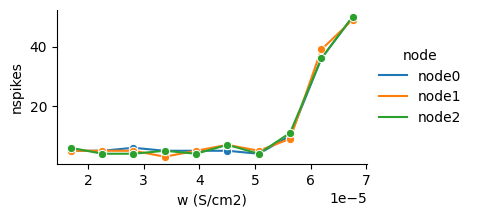

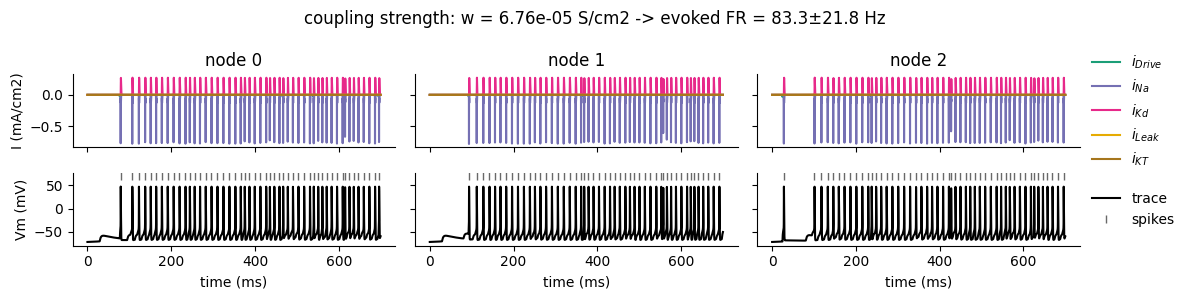

In [21]:
# Assign baseline pre-synaptic drive
model.set_presyn_drive(freq=drive_freq, noise=noise)

# Run simulation and plot results
data = model.simulate(tstop=tstop)
mu_FR, err_FR = model.compute_metric(data, 'FR').mean(axis=0)
FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
fig = model.plot_results(data, exclude=['conductances', 'T'])
fig.suptitle(f'coupling strength: w = {model.get_synaptic_weight():.2e} S/cm2 -> evoked FR = {FR_str}')

# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(1, 4, 10) * model.g_RS_RS

# Run simulation for each coupling strength, and concatenate results
data = []
model.verbose = False
for w in tqdm(wrange):
    model.set_synaptic_weight(w)
    data.append(model.simulate(nreps=nreps))
model.verbose = True
data = pd.concat(data, keys=wrange, names=['w (S/cm2)'])

# Plot dependency of evoked firing rate on coupling strength
fig = model.plot_sweep_results(data, 'nspikes')

# Plot results for largest coupling strength
idx = (wrange[-1], 0) if 'rep' in data.index.names else wrange[-1]
data = data.loc[idx]
mu_FR, err_FR = model.compute_metric(data, 'FR').mean(axis=0)
FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
fig = model.plot_results(data, exclude=['conductances', 'T'])
fig.suptitle(f'coupling strength: w = {model.get_synaptic_weight():.2e} S/cm2 -> evoked FR = {FR_str}')

# Reset synaptic weight to default value
model.set_synaptic_weight(model.g_RS_RS)

### Inspect stimulus-evoked responses with various synaptic coupling strengths

 03/12/2023 14:02:45: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2
 03/12/2023 14:02:45: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 14:02:45: NeuralNetwork(3): disabled currents: iM, iNaKPump
 03/12/2023 14:02:45: NeuralNetwork(3): simulating for 700.00 ms
 03/12/2023 14:02:45: NeuralNetwork(3): extracting output results
 03/12/2023 14:02:46: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.4 °C
    - node 1: ΔT = 0.4 °C
    - node 2: ΔT = 0.4 °C
 03/12/2023 14:02:46: NeuralNetwork(3): number of spikes:
    - node 0: n = 6 spikes
    - node 1: n = 6 spikes
    - node 2: n = 5 spikes
 03/12/2023 14:02:46: NeuralNetwork(3): firing rate:
    - node 0: FR = 9.1 ±1.3 Hz
    - node 1: FR = 8.6 ±2.7 Hz
    - node 2: FR = 8.4 ±1.9 Hz
 03/12/2023 14:02:46: NeuralNetwork(3): stimulus response:
    - node 0: ΔFR/FR = -26.7 %
    - node 1: ΔFR/

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


 03/12/2023 14:02:54: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2


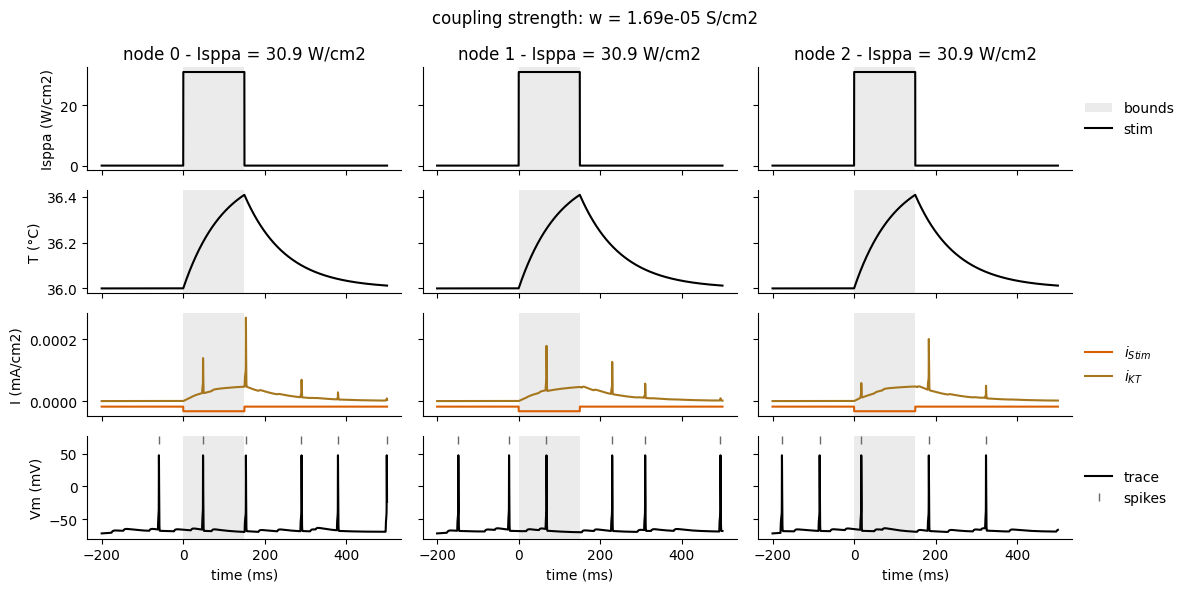

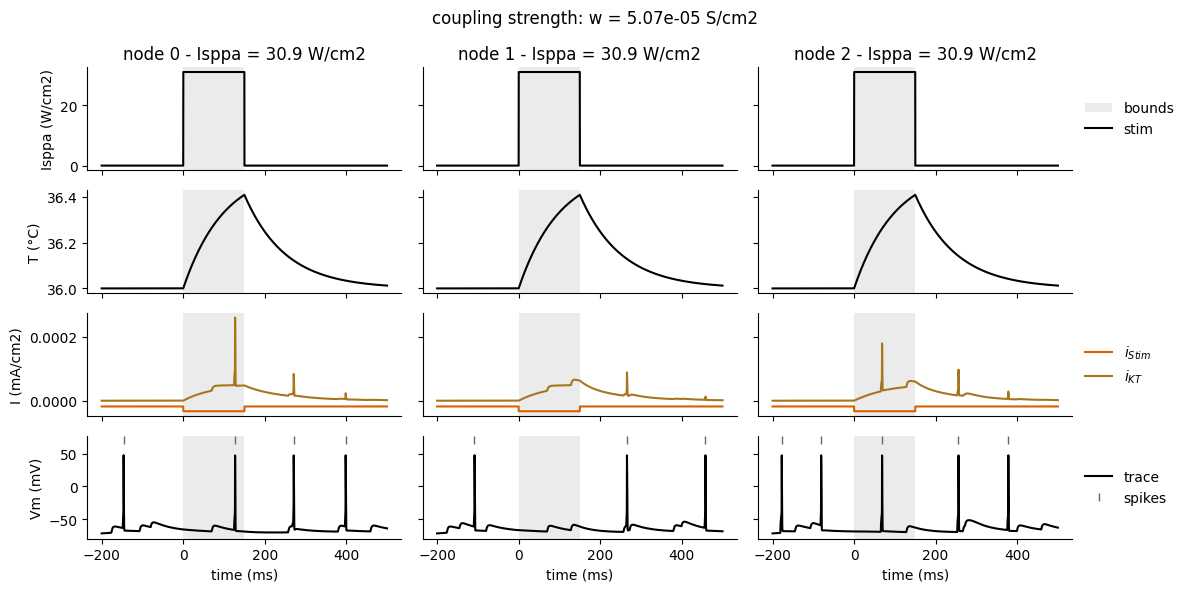

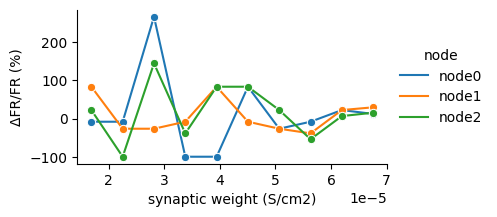

In [24]:
# # Remove baseline pre-synaptic drive
# model.remove_presyn_drive()

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# Define sparse vector of coupling strengths (in S/cm2)
wrange_sparse = np.array([1, 3]) * model.g_RS_RS

# For each coupling strength, run simulation and plot results
for w in wrange_sparse:
    model.set_synaptic_weight(w)
    data = model.simulate(tstop=tstop)
    fig = model.plot_results(data, exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iDrive'])
    fig.suptitle(f'coupling strength: w = {model.get_synaptic_weight():.2e} S/cm2')

# Run simulation for each coupling strength, and concatenate results
data = []
model.verbose = False
for w in tqdm(wrange):
    model.set_synaptic_weight(w)
    data.append(model.simulate(nreps=nreps))
model.verbose = True
data = pd.concat(data, keys=wrange, names=['synaptic weight (S/cm2)'])

# Plot dependency of evoked response on coupling strength
fig = model.plot_sweep_results(data, sweep_metrics)

# Reset synaptic weight to default value
model.set_synaptic_weight(model.g_RS_RS)

### Inpsect combined impact of stimulus sensitivity and coupling strength on spiking activity

In [25]:
# # Define vector of coupling strengths (in S/cm2)
# wrange = np.linspace(1, 4, 10) * model.g_RS_RS

# # Define vector of stimulus sensitivities (in mA/W)
# Ɣrange = np.array([4e-6, 1e-5, 2e-5])

# # For each stimulus sensitivity
# nreps = 3
# data = []
# for Ɣ in Ɣrange:
#     model.set_mech_param(gamma=Ɣ)

#     # Run simulation for each coupling strength
#     model.verbose = False
#     for w in tqdm(wrange):
#         model.set_synaptic_weight(w)
#         data.append(model.simulate(nreps=nreps))
#     model.verbose = True

# # Concatenate results
# data = pd.concat(
#     data, 
#     keys=list(itertools.product(Ɣrange, wrange)), 
#     names=['Ɣ (S/cm2)', 'w (S/cm2)'])

# # Plot dependency of evoked firing rate on coupling strength
# model.plot_sweep_results(data, 'nspikes')

# # Set parameters to enable strong evoked response without tonic firing
# model.set_mech_param(gamma=2e-5)
# model.set_synaptic_weight(5e-5)

# # Run simulation and plot results
# data = model.simulate()
# fig = model.plot_results(data, exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iDrive'])

# # Reset gamma and synaptic weight to their default values
# model.set_mech_param(gamma=params['gamma'])
# model.set_synaptic_weight(model.g_RS_RS)

### Inpspect combined impact of stimulus sensitivity and coupling strength on stimulus-evoked responses, across Isppa range

 01/12/2023 10:14:58: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:14:58: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


 01/12/2023 10:15:18: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:15:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


 01/12/2023 10:15:37: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 01/12/2023 10:15:37: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


 01/12/2023 10:15:56: NeuralNetwork(3): setting gamma = 1e-05 on all nodes
 01/12/2023 10:15:56: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:15:56: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


 01/12/2023 10:16:17: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:16:17: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


 01/12/2023 10:16:35: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 01/12/2023 10:16:35: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


 01/12/2023 10:16:54: NeuralNetwork(3): setting gamma = 2e-05 on all nodes
 01/12/2023 10:16:54: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:16:54: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


 01/12/2023 10:17:14: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:17:14: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


 01/12/2023 10:17:32: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 01/12/2023 10:17:32: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


 01/12/2023 10:18:03: NeuralNetwork(3): setting gamma = 4e-06 on all nodes
 01/12/2023 10:18:03: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:18:03: plotting results...


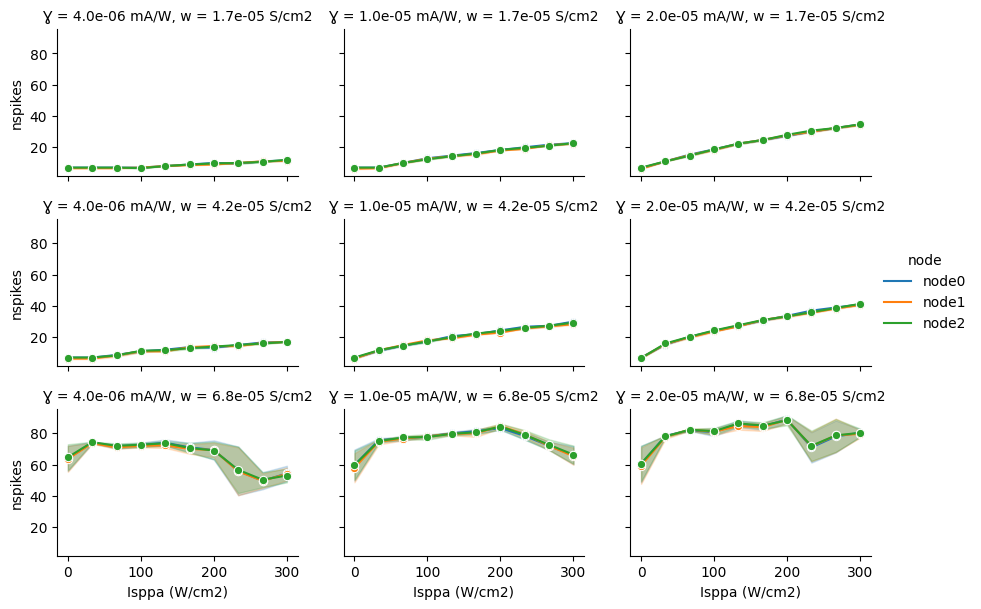

In [12]:
# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(1, 4, 3) * model.g_RS_RS

# Define vector of stimulus sensitivities (in mA/W)
iStim_Ɣrange = np.array([4e-6, 1e-5, 2e-5])

# Define vector of stimulus intensities (in W/cm2)
Isppa_range = np.linspace(0, 300, 10)

# For each stimulus sensitivity
nreps = 3
data, keys = [], []
for Ɣ in Ɣrange:
    model.set_mech_param(gamma=Ɣ)
    # For each coupling strength
    for w in wrange:
        model.set_synaptic_weight(w)
        # Run sweep over stimulus intensities, and plot results
        data.append(model.run_stim_sweep(Isppa_range, nreps=nreps))
        keys.append((Ɣ, w))

# Concatenate results
data = pd.concat(data, keys=keys, names=['Ɣ (mA/W)', 'w (S/cm2)'])

# Reset gamma and synaptic weight to their default values
model.set_mech_param(gamma=params['gamma'])
model.set_synaptic_weight(model.g_RS_RS)

# Plot results
logger.info('plotting results...')
fg = sns.FacetGrid(
    data.reset_index(),
    col='Ɣ (mA/W)',
    row='w (S/cm2)',
    aspect=1.5,
    height=2,
)
fg.set_titles('Ɣ = {col_name:.1e} mA/W, w = {row_name:.1e} S/cm2')
for iw, w in enumerate(wrange):
    for ig, Ɣ in enumerate(Ɣrange):
        gdata = data.loc[Ɣ, w]
        model.plot_sweep_results(
            gdata, 'nspikes', ax=fg.axes[iw, ig], legend=iw == 1 and ig == 2)
fig = fg.figure

### Compare evoked responses for single node vs. multi-node stimulation 

 01/12/2023 10:23:25: NeuralNetwork(3): setting gamma = 1e-05 on all nodes
 01/12/2023 10:23:25: NeuralNetwork(3): setting all synaptic weights to 2.00e-05 S/cm2
 01/12/2023 10:23:25: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 61.8 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 01/12/2023 10:23:25: NeuralNetwork(3): disabled currents: iM, iNaKPump
 01/12/2023 10:23:25: NeuralNetwork(3): simulating for 1000.00 ms
 01/12/2023 10:23:26: NeuralNetwork(3): extracting output results
 01/12/2023 10:23:26: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.8 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 01/12/2023 10:23:26: NeuralNetwork(3): number of elicited spikes:
    - node 0: n = 10 spikes
    - node 1: n = 6 spikes
    - node 2: n = 7 spikes
 01/12/2023 10:23:26: NeuralNetwork(3): elicited firing rate:
    - node 0: FR = 28.4 ±44.3 Hz
    - node 1: FR = 7.0 ±0.6 Hz
    - node 2: FR = 7.3 ±0.3 Hz
 01/12/2023 1

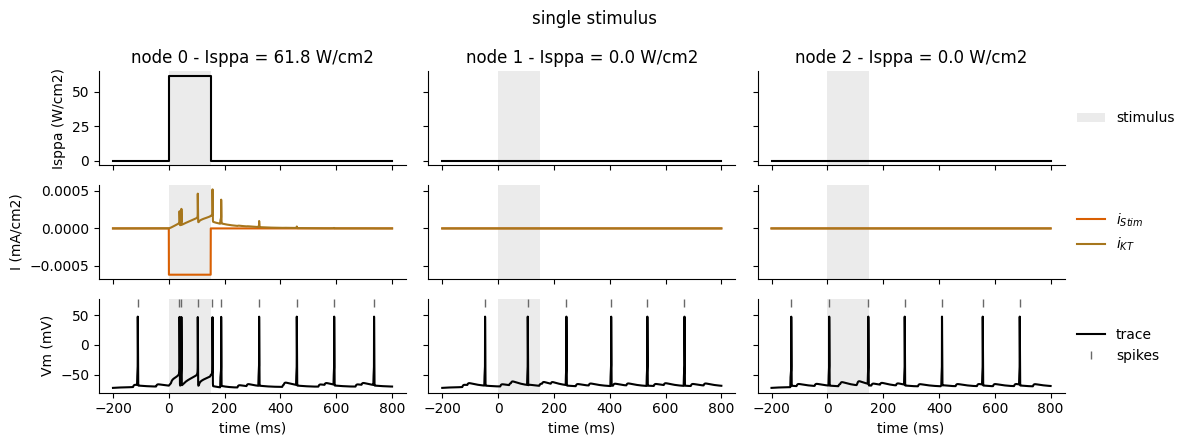

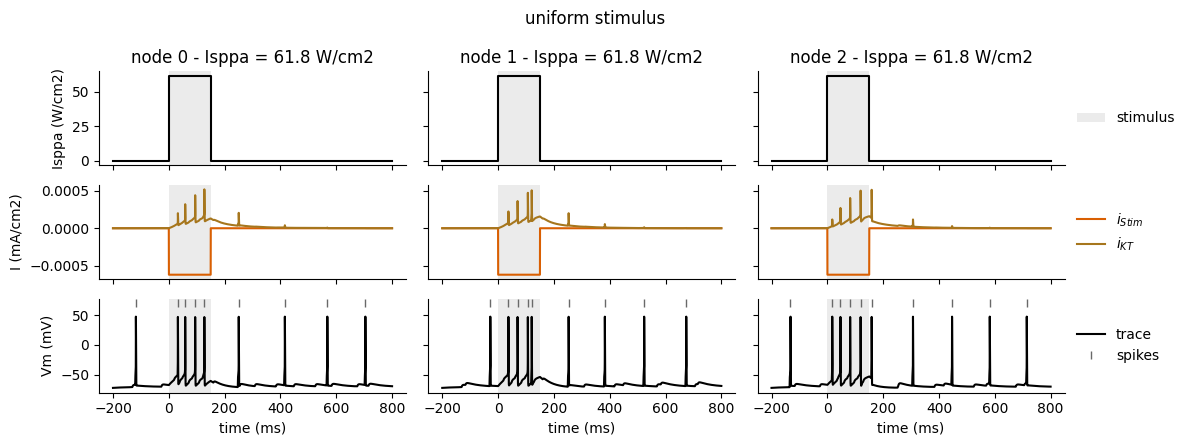

In [13]:
# Define vector of stimulus intensities per node (in W/cm2) for both 
# single and multi-node stimulation
dists = {k: model.get_stimdist_vector(kind=k) for k in ['single', 'uniform']}

# Set stimulus sensitivity and synaptic weight
model.set_mech_param(gamma=1e-5)
model.set_synaptic_weight(2e-5)

# For each stimulus distribtion, run simulation and plot results
for k, xvec in dists.items():
    model.set_stim(2 * Iref * xvec)
    data = model.simulate(tstop=tstop)
    fig = model.plot_results(data, exclude=['conductances', 'T', 'iNa', 'iKd', 'iLeak', 'iDrive'])
    fig.suptitle(f'{k} stimulus')

# Reset stimulus to default value
model.set_stim(Iref)

### Inspect Isppa dependency curves for single-node vs multi-node stimulation

 01/12/2023 10:43:03: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:43:03: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


 01/12/2023 10:43:24: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


 01/12/2023 10:43:44: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:43:44: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


 01/12/2023 10:44:04: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


 01/12/2023 10:44:24: NeuralNetwork(3): setting gamma = 1e-05 on all nodes
 01/12/2023 10:44:24: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:44:24: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


 01/12/2023 10:44:43: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


 01/12/2023 10:45:04: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:45:04: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


 01/12/2023 10:45:22: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


 01/12/2023 10:45:42: NeuralNetwork(3): setting gamma = 2e-05 on all nodes
 01/12/2023 10:45:42: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:45:42: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


 01/12/2023 10:46:01: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


 01/12/2023 10:46:20: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 01/12/2023 10:46:20: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


 01/12/2023 10:46:39: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


 01/12/2023 10:47:14: NeuralNetwork(3): setting gamma = 4e-06 on all nodes
 01/12/2023 10:47:14: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 01/12/2023 10:47:14: plotting results...
 01/12/2023 10:49:12: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


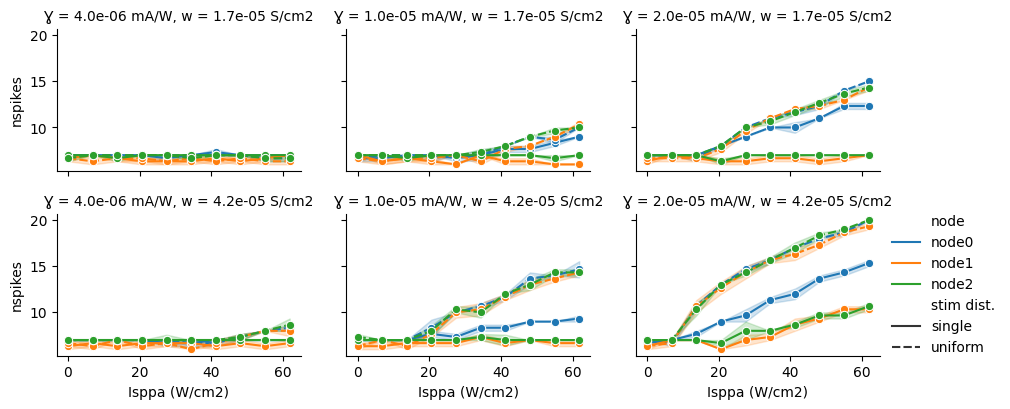

In [20]:
# Sweep parameters
Isppa_range = np.linspace(0, 2 * Iref, 10)

# Define vector of coupling strengths (in S/cm2)
wrange = np.array([1, 2.5]) * model.g_RS_RS

# For each stimulus sensitivity
nreps = 3
data, keys = [], []
for Ɣ in Ɣrange:
    model.set_mech_param(gamma=Ɣ)
    # For each coupling strength
    for w in wrange:
        model.set_synaptic_weight(w)
        # For each stimulus distribution
        for k, xvec in dists.items():
            # Run sweep over stimulus intensities, and append results to list
            data.append(model.run_stim_sweep(Isppa_range, stimdist=xvec, nreps=nreps))
            keys.append((Ɣ, w, k))

# Concatenate results
data = pd.concat(data, keys=keys, names=['Ɣ (mA/W)', 'w (S/cm2)', 'stim dist.'])

# Reset gamma and synaptic weight to their default values
model.set_mech_param(gamma=params['gamma'])
model.set_synaptic_weight(model.g_RS_RS)

# Plot results
logger.info('plotting results...')
fg = sns.FacetGrid(
    data.reset_index(),
    col='Ɣ (mA/W)',
    row='w (S/cm2)',
    aspect=1.5,
    height=2,
)
fg.set_titles('Ɣ = {col_name:.1e} mA/W, w = {row_name:.1e} S/cm2')
for iw, w in enumerate(wrange):
    for ig, Ɣ in enumerate(Ɣrange):
        gdata = data.loc[Ɣ, w]
        model.plot_sweep_results(
            gdata, 'nspikes', ax=fg.axes[iw, ig], legend=iw == 1 and ig == 2)
fig = fg.figure

# Reset stimulus amplitude to reference value
model.set_stim(Iref)

## Log completion

In [ ]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 02/12/2023 16:07:19: notebook completed in 0:07:05.659175
